<a href="https://colab.research.google.com/github/CatrielBartezaghi/Price_Indicator_Using_ANN/blob/main/TPF_MLP_BARTEZAGHI_LUENGO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Instalacion Librerias

In [ ]:
!pip install pandas_ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


###Funciones

In [ ]:
from datetime import datetime
from sqlite3 import Timestamp
import sys
import plotly.express as px
import pandas_ta as ta
import time
import calendar
from sklearn.model_selection import train_test_split

from distutils.log import error

from time import sleep
import numpy as np
import matplotlib.pyplot as plt
from fileinput import filename
import pandas as pd
from numpy import imag
from pprint import pprint
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error 



def preproceso_y_escalado(val,rango1,rango2,descarte=0):  #Escala los valores y elimina los null. El descarte es cuanto de los primero valores eliminas
    scaler = MinMaxScaler(feature_range=(rango1, rango2))  
    val = val.fillna(method='ffill')
    val = scaler.fit_transform(val.values.reshape(-1,1))
    val = val[descarte:] #Descarto los primero valores para que me coincida con la cantidad de precios que voy a usar despues

    val = np.squeeze(val) #Le saca una dimension
    
    return val
    

def relacion_media_precio(Price,Median): #Contar valores de precio que estan por encima de la media.
    nan_values = np.count_nonzero(np.isnan(Median))
    if(nan_values>0):
        print("Faltan valores de media. valores nulos= "+str(nan_values))
    
    cant_mayor_precio = np.count_nonzero(Price>Median)
    coef = cant_mayor_precio/len(Price)
    return coef


def armar_dataset(Close,Indicadores,Ema,n,m): #n= val anteriores  m=valores posteriores (a predecir)  #Indicadores = Array de arrays [RSI, MACD, ADX...]
    Xd = []   
    Yd = []
    i=n
    while(i<len(Close)-m):
        Xdd=[] 
        for j in range(len(Indicadores)): #Recorro cada indicador
            indicador_j = Indicadores[j] 
            rango_val = indicador_j[i-n:i] #tomo n valores hacia atras            
            Xdd.extend(rango_val)

        Xd.append(Xdd)
        salida = relacion_media_precio(Close[i:i+m],Ema[i:i+m]) #Vemos que tan alcista fue los proximos m dias
        Yd.append([salida])
        
        i=i+1
    
    return Xd, Yd  


def simulacion_compra(y_pred,val_compra,val_venta,close,monto,graficar=True):
    estado = "buy"
    monto_inicial = monto
    acciones = 0

    
    
    for i in range(len(y_pred)):
        if(y_pred[i]>=val_compra and estado == "buy"):  #Compramos
            acciones = monto/close[i]
            estado = "sell"
            if(graficar):
              plt.scatter(i,[close[i]],color='green')
        if(y_pred[i]<=val_venta and estado == "sell"):  #Vendemos
            monto = acciones*close[i]
            estado = "buy"

            if(graficar):
               plt.scatter([i],[close[i]],color='red')
            
    porcentaje = monto/monto_inicial
    
    return monto, porcentaje     


def simulacion_compra_test(y_test,val_compra,val_venta,close,monto,graficar=True):
    estado = "buy"
    monto_inicial = monto
    acciones = 0
    for i in range(len(y_test)):
        if(y_test[i][0]>=val_compra and estado == "buy"):  #Compramos
            acciones = monto/close[i]
            estado = "sell"

            if(graficar):
              plt.scatter(i,close[i],marker=4,color= 'green')
        if(y_test[i][0]<=val_venta and estado == "sell"):  #Vendemos
            monto = acciones*close[i]
            estado = "buy"

            if(graficar):
              plt.scatter(i,close[i],marker=4,color= 'red')

    porcentaje = monto/monto_inicial
    
    return monto, porcentaje    


def simulacion_compra_con_stop(y_pred,val_compra,val_venta,close,monto,graficar=True,stop_porc = 0.03,simbolo_graf = 2,simbolo_stop=1,operacion="Pred"):
    estado = "buy"
    monto_inicial = monto
    acciones = 0
    
    C1 = []
    C2 = []

    V1 = []
    V2 = []

    S1 = []
    S2 = []
    for i in range(len(y_pred)):
        if(y_pred[i]>=val_compra and estado == "buy"):  #Compramos
            acciones = monto/close[i]
            precio_stop = close[i]*(1-stop_porc)
            estado = "sell"
            if(graficar):
              C1.append(i)
              C2.append(close[i])
              
            

        if(estado == "sell" and y_pred[i]<=val_venta):  #Venta
            monto = acciones*close[i]
            estado = "buy"
            if(graficar):
              V1.append(i)
              V2.append(close[i])
              
              

        if(estado == "sell" and close[i]<precio_stop):  #Venta por stop loss
          monto = acciones*precio_stop
          estado = "buy"
          if(graficar):
            
              S1.append(i)
              S2.append(precio_stop)

    porcentaje = monto/monto_inicial
    if(graficar):
      plt.scatter(C1,C2,color='green',marker=simbolo_graf,label='Compra '+str(operacion))
      plt.scatter(V1,V2,color='red',marker=simbolo_graf,label='Venta '+str(operacion))
   
    return monto, porcentaje 


###Obtencion de Datos

In [ ]:

#------------Obtencion de datos------------

ticket = 'AAPL'
fecha = '2010-01-01 00:00:00'
# period1 = str(int(datetime.timestamp(datetime.now())) -  31556926* 1 )  #Ultimo num = Años hacias atras a partir de hoy
period1 = str(calendar.timegm(time.strptime(fecha, '%Y-%m-%d %H:%M:%S')))
period2 = str(int(datetime.timestamp(datetime.now())))  #Fecha de hoy
interval = '1d'
request = 'https://query1.finance.yahoo.com/v7/finance/download/'+ticket+'?period1='+period1+'&period2='+period2+'&interval='+interval+'&events=history&includeAdjustedClose=true'


#-----Organizacion de datos--------
ema_comp = 20 #Media para comparar la salida
EMAs = [20,50,200] #Vector con medias a utilizar.
ema_max = np.max(EMAs)
df = pd.read_csv(request)
df_indic = df
df = df[np.max(EMAs):]

open = df['Open'] #Precio apertura en el mercado
close = df['Close']  #Precio de cierre de mercado
low = df['Low']
high = df['High']

close_indic = df_indic['Close']  #Precios para usar en los indicadores
open_indic = df_indic['Open'] #Precio apertura en el mercado
low_indic = df_indic['Low']
high_indic = df_indic['High']



###Calculo de Indicadores

In [ ]:

#----------Indicadores tecnicos-------------

rsi = ta.rsi(close_indic,14)
rsi_n = preproceso_y_escalado(rsi,0,1,ema_max)

adx = ta.adx(high_indic,low_indic,close_indic,14)  #Contiene 3 indicadores
adx_n = preproceso_y_escalado(adx['ADX_14'],0,1,ema_max)
dmp_n = preproceso_y_escalado(adx['DMP_14'],0,1,ema_max) #DMI positivo
dmn_n = preproceso_y_escalado(adx['DMN_14'],0,1,ema_max) #DMI negativo

macd = ta.macd(close_indic,12,26,9)
macd_n = preproceso_y_escalado(macd['MACD_12_26_9'],0,1,ema_max)
macdh_n = preproceso_y_escalado(macd['MACDh_12_26_9'],0,1,ema_max)
macds_n = preproceso_y_escalado(macd['MACDs_12_26_9'],0,1,ema_max)

psar = ta.psar(high_indic,low_indic,close_indic,0.02,0.02,0.2)
psar_n = preproceso_y_escalado(psar['PSARr_0.02_0.2'],0,1,ema_max)  #Solo devuelve 0 o 1. 1=compra, 0=venta.  Ver funcion de activacion si no cambia.

ema20 = ta.ema(close_indic,EMAs[0])[ema_max:]  #NO ESTA NORMALIZADA
ema50 = ta.ema(close_indic,EMAs[1])[ema_max:]
ema200 = ta.ema(close_indic,EMAs[2])[ema_max:]

#twitter = data_tw[-len(close):]

Indicadores = [rsi_n,adx_n,dmp_n,dmn_n,macd_n,macdh_n,macds_n]#,psar_n]

###Armado de Dataset

In [ ]:

#------Armado de dataset---------

ema_c = ta.ema(close_indic,ema_comp)[ema_max:]

n_entrada = 10  #Cant de periodos (ejemplo: dias) anteriores para usar de entrada
n_salida = 5  #Cant de periodos posteriores para calcular la salida
Xd,Yd = armar_dataset(close,Indicadores,ema_c,n_entrada,n_salida)

###Test con valores esperados

In [ ]:
#Se realizan compras y ventas de acuerdo al valor esperado o salida correcta de la red
monto = 100
val_compra = 0.8  #Valor con el que el indicador realiza una compra
val_venta = 0.3  #Valor con el que el indicador realiza una venta


k = 2 #Cant valores a predecir despues de cada entrenamiento i. Es decir, se entrena con todos los valores anteriores y se hace la prediccion de los proximos k valores
n_test = 300  #Total de valores a predecir
stop_porc = 0.03

y_test = Yd[-n_test:]
monto_final_test, rendimiento_test = simulacion_compra_test(y_test,val_compra,val_venta,close[-(len(y_test)+n_salida):-n_salida].to_numpy(),monto,False)
print("Monto inicial: ", monto)
print("Monto final: ", monto_final_test)
print("Rendimiento de " + str(rendimiento_test) + " en " + str(len(y_test)) + " dias")

Monto inicial:  100
Monto final:  185.8626108607247
Rendimiento de 1.8586261086072469 en 300 dias


###Red Neuronal

In [ ]:

n_input = len(Xd[0])
n_hidden = 100
n_out = len(Yd[0])


losses = []
epocas = 3000


Y_Pred = []

xdd_tr = Xd[0:len(Xd)-n_test]
ydd_tr = Yd[0:len(Xd)-n_test]
xdd_rest = Xd[-n_test:]  #Valores restantes
ydd_rest = Yd[-n_test:]

i=0
while (i<n_test):
    model = nn.Sequential(nn.Linear(n_input, n_hidden),
                        nn.Sigmoid(),
                        nn.Linear(n_hidden, n_out),
                        nn.Sigmoid())

    loss_function = nn.MSELoss()  #Funcion de error en la salida

    optimizer = torch.optim.Adam(model.parameters())
    print("iteracion: ",i)
    
    #Mezclar datos de entrenamiento
    # indx = np.random.randint(0,len(X_train),len(X_train))
    # X_train = np.array(X_train)[indx.astype(int)]
    # y_train = np.array(y_train)[indx.astype(int)]
    
    
    X_train_tensor = torch.FloatTensor(xdd_tr[0:-n_salida])
    y_train_tensor = torch.FloatTensor(ydd_tr[0:-n_salida])
    
    xdd_tst = xdd_rest[i:i+k]
    ydd_tst = ydd_rest[i:i+k]
    
    X_test_tensor = torch.FloatTensor(xdd_tst)  #Tomamos k valor para test
    y_test_tensor = torch.FloatTensor(ydd_tst)
    
    xdd_tr.extend(xdd_tst[i:i+k])  #agregamos para entrenar en la proxima iteracion
    ydd_tr.extend(ydd_tst[i:i+k])
    
    model.train()
    for epoch in range(epocas):
        optimizer.zero_grad()
        # model.zero_grad()
        pred_y = model(X_train_tensor)
        loss = loss_function(y_train_tensor,pred_y)

        losses.append(loss.item())
        loss.backward()
        optimizer.step()  #Ajuste pesos


    model.eval()  #Desactiva capas que se usan en entrenamiento
    y_test_pred = model(X_test_tensor)
    y_pred_numpy = y_test_pred.cpu().detach().numpy()
    y_pred_numpy = np.squeeze(y_pred_numpy)
    Y_Pred.extend(y_pred_numpy)


    i=i+k


iteracion:  0
iteracion:  2
iteracion:  4
iteracion:  6
iteracion:  8
iteracion:  10
iteracion:  12
iteracion:  14
iteracion:  16
iteracion:  18
iteracion:  20
iteracion:  22
iteracion:  24
iteracion:  26
iteracion:  28
iteracion:  30
iteracion:  32
iteracion:  34
iteracion:  36
iteracion:  38
iteracion:  40
iteracion:  42
iteracion:  44
iteracion:  46
iteracion:  48
iteracion:  50
iteracion:  52
iteracion:  54
iteracion:  56
iteracion:  58
iteracion:  60
iteracion:  62
iteracion:  64
iteracion:  66
iteracion:  68
iteracion:  70
iteracion:  72
iteracion:  74
iteracion:  76
iteracion:  78
iteracion:  80
iteracion:  82
iteracion:  84
iteracion:  86
iteracion:  88
iteracion:  90
iteracion:  92
iteracion:  94
iteracion:  96
iteracion:  98
iteracion:  100
iteracion:  102
iteracion:  104
iteracion:  106
iteracion:  108
iteracion:  110
iteracion:  112
iteracion:  114
iteracion:  116
iteracion:  118
iteracion:  120
iteracion:  122
iteracion:  124
iteracion:  126
iteracion:  128
iteracion:  130

###Test con salidas de la red

In [ ]:

precios = close[-(len(Y_Pred)+n_salida):-n_salida].to_numpy()  #Descartamos ultimos 10 porque no los usamos en el dataset

# monto_final, rendimiento = simulacion_compra(Y_Pred,val_compra,val_venta,precios,monto,False)

monto_final, rendimiento = simulacion_compra_con_stop(Y_Pred,val_compra,val_venta,precios,monto,False,stop_porc)
MSE = mean_squared_error(Y_Pred,y_test)

print("MSE Prediccion: ", MSE)
print("Monto inicial: ", monto)
print("Monto final: ", monto_final)
print("Rendimiento de " + str(rendimiento) + " en " + str(len(Y_Pred)) + " dias")


MSE Prediccion:  0.09609266441873575
Monto inicial:  100
Monto final:  112.13250320815335
Rendimiento de 1.1213250320815336 en 300 dias


###Gráficas

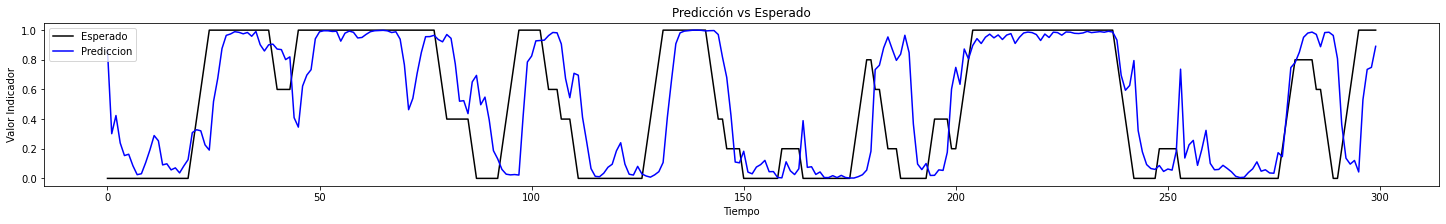

In [ ]:
plt.figure(figsize=(25,3))
plt.plot(y_test,'black')
plt.plot(Y_Pred,'blue')
plt.xlabel("Tiempo")
plt.ylabel("Valor Indicador")
plt.title("Predicción vs Esperado")

plt.legend(["Esperado" , "Prediccion"])

plt.show()

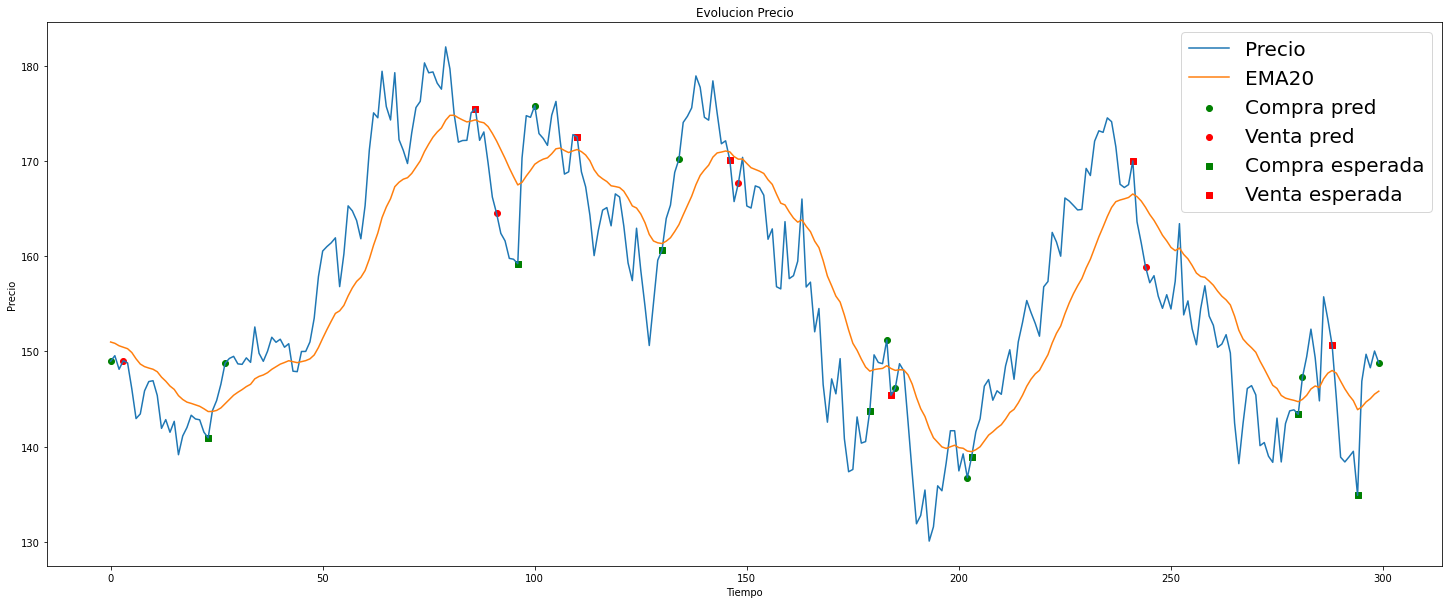

In [ ]:

plt.figure(figsize=(25,10))
plt.plot(precios,label='Precio')
plt.plot(ema_c[-(len(Y_Pred)+n_salida):-n_salida].to_numpy(),label = 'EMA'+str(ema_comp))
plt.xlabel("Tiempo")
plt.ylabel("Precio")
plt.title('Evolucion Precio')

simulacion_compra_con_stop(Y_Pred,val_compra,val_venta,precios,monto,True,stop_porc,simbolo_graf=None,simbolo_stop='_',operacion="pred")  #prediccion

simulacion_compra_con_stop(np.squeeze(y_test),val_compra,val_venta,precios,monto,True,stop_porc,simbolo_graf='s',simbolo_stop='',operacion="esperada")  #esperado

plt.legend(fontsize=20)
